In [25]:
SEED = 123456
import os
import random as rn
import numpy as np
os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
rn.seed(SEED)

import time 
start_time = time.time()

import pandas as pd
import numpy as np
import cv2    
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

from keras.applications.inception_v3 import InceptionV3, preprocess_input

from keras import optimizers
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras import backend as K

from keras.models import Sequential, Model 
from keras.layers import Conv2D, Dense, MaxPool2D, Dropout, Flatten
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import np_utils
from keras.optimizers import SGD
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import History 

from IPython.core.display import display, HTML
from PIL import Image
from io import BytesIO
import base64

plt.style.use('ggplot')

%matplotlib inline
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.004010200500488281 seconds ---


In [2]:
import tensorflow as tf
tf.random.set_seed(1234)
print(tf.__version__)

2.3.0


In [3]:
## Define Variables
main_folder = 'data_/'
images_folder = main_folder + 'images/'
EXAMPLE_PIC = images_folder + '1.png'
# ex = cv2.imread(EXAMPLE_PIC)
# cv2.imshow("example",ex)
# cv2.waitKey(0)
TRAINING_SAMPLES = 200
VALIDATION_SAMPLES = 30
TEST_SAMPLES = 30
IMG_WIDTH = 32
IMG_HEIGHT = 32
BATCH_SIZE = 4
NUM_EPOCHS = 20

In [4]:
## Import Data
df_attr = pd.read_csv(main_folder + 'data.csv')
#df_attr.set_index('images', inplace=True)
print(df_attr.shape)
df_attr.head()
#print(np.sum(df_attr.iloc[:,1]==0))

(277, 3)


,images,normal,partition
0,0,0,2
1,1,0,2
2,2,0,2
3,3,0,2
4,4,0,2


In [5]:
for i in df_attr["images"]:
    df_attr["images"][i]= "{}.png".format(i)
    
df_attr

<ipython-input-5-7d3430f4414e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_attr["images"][i]= "{}.png".format(i)


,images,normal,partition
0,0.png,0,2
1,1.png,0,2
2,2.png,0,2
3,3.png,0,2
4,4.png,0,2
...,...,...,...
272,272.png,1,0
273,273.png,1,0
274,274.png,1,0
275,275.png,1,0


(200, 200, 3)


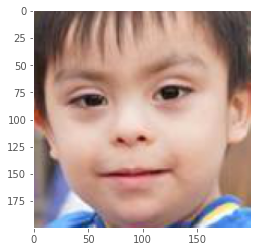

In [6]:
## Pic Example
img = load_img(EXAMPLE_PIC)
print(np.array(img).shape)
plt.grid(False)
plt.imshow(img)

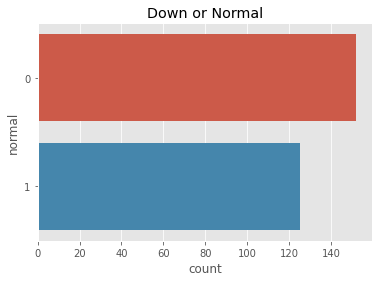

In [7]:
# Female or Male?
plt.title('Down or Normal')
sns.countplot(y= "normal", data=df_attr)
plt.show()

In [8]:
## Generate (Train, Val & Test)
def load_reshape_img(fname):
    img = load_img(fname,target_size=(32,32))
    x = img_to_array(img)/255.
    x = x.reshape( x.shape)
    return x


def generate_df(partition, attr, num_samples):
    '''
    partition
        0 -> train
        1 -> validation
        2 -> test
    
    '''
    
    df_ = df_attr[(df_attr['partition'] == partition) 
                           & (df_attr[attr] == 0)].sample(int(num_samples/2))
    df_ = pd.concat([df_,
                      df_attr[(df_attr['partition'] == partition) 
                                  & (df_attr[attr] == 1)].sample(int(num_samples/2),replace=True)])
    
    # for Train and Validation
    if partition != 2:
        x_ = np.asarray([load_reshape_img(images_folder + fname) for fname in df_["images"]])
#         x_ = x_.reshape(x_.shape[0], 32, 32, 3)
        y_ = np_utils.to_categorical(df_[attr],2)
        
    # for Test
    else:
        x_ = []
        y_ = []

        for index, target in df_.iterrows():
            im = cv2.imread('{}{}.png'.format(images_folder, index))
            im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (IMG_WIDTH, IMG_HEIGHT)).astype(np.float32) / 255.0
            im = np.expand_dims(im, axis =0)
            x_.append(im)
            y_.append(target[attr])

    return x_, y_

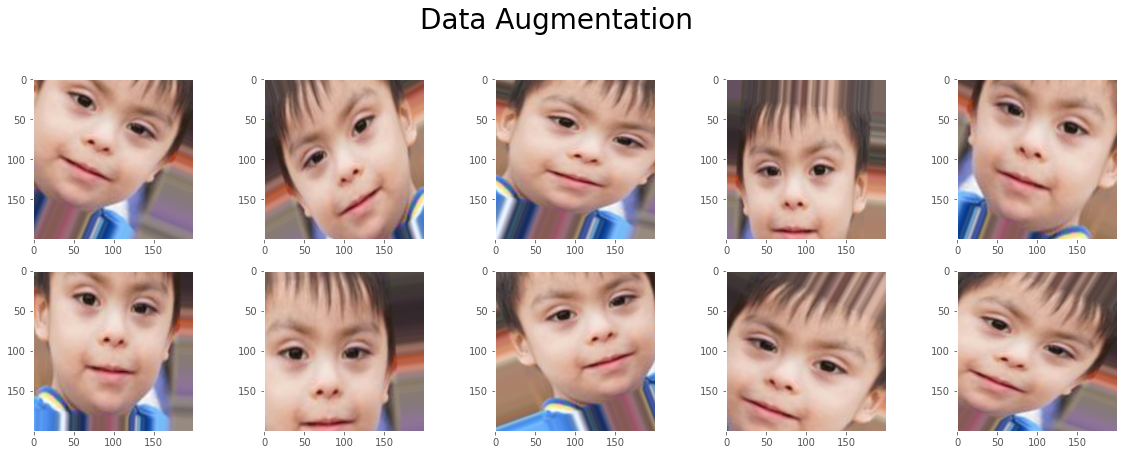

In [9]:
## Data Augmentation Ex
datagen =  ImageDataGenerator(
  #preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True
)
# load one image and reshape
img = load_img(EXAMPLE_PIC)
x = img_to_array(img)/255.
x = x.reshape((1,) + x.shape)

# plot 10 augmented images of the loaded iamge
plt.figure(figsize=(20,10))
plt.suptitle('Data Augmentation', fontsize=28)

i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.subplot(3, 5, i+1)
    plt.grid(False)
    plt.imshow( batch.reshape(200, 200, 3))
    
    if i == 9:
        break
    i += 1
    
plt.show()

In [10]:
start_time = time.time()

## Data Agumentaion
x_train, y_train = generate_df(0, 'normal', TRAINING_SAMPLES)

# Train - Data Preparation - Data Augmentation with generators
train_datagen =  ImageDataGenerator(
  preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  ##zoom_range=0.2,
  horizontal_flip=True,
)

train_datagen.fit(x_train)

train_generator = train_datagen.flow(
x_train, y_train,
batch_size=BATCH_SIZE,
)
print("--- %s seconds ---" % (time.time() - start_time))

--- 1.1454498767852783 seconds ---


In [11]:
print(type(train_generator))
print(x_train.shape)

<class 'tensorflow.python.keras.preprocessing.image.NumpyArrayIterator'>
(200, 32, 32, 3)


In [12]:
## Data Agumentaion
# # Validation Data
x_valid, y_valid = generate_df(1, 'normal', VALIDATION_SAMPLES)


# Validation - Data Preparation - Data Augmentation with generators
valid_datagen = ImageDataGenerator(
  preprocessing_function=preprocess_input,
)

valid_datagen.fit(x_valid)

validation_generator = valid_datagen.flow(
x_valid, y_valid,
)


In [13]:
# start_time = time.time()

# ## Create Final Model (TOp + Custom) layers
# model_ = Model(inputs=inc_model.input, outputs=predictions)

# # Lock initial layers to do not be trained
# for layer in model_.layers[:52]:
#     layer.trainable = False

# # compile the model
# model_.compile(optimizer=SGD(lr=0.0001, momentum=0.9)
#                     , loss='categorical_crossentropy'
#                     , metrics=['accuracy'])

# print("--- %s seconds ---" % (time.time() - start_time))

In [14]:
## NN model

start_time = time.time()

model = Sequential()
model.add(Conv2D(filters=6, kernel_size=(5,5), padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(filters=16, kernel_size=(5,5), padding='valid', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(120, activation='relu'))
model.add(Dense(84, activation='relu'))
model.add(Dense(2, activation='softmax'))


print("--- %s seconds ---" % (time.time() - start_time))


--- 0.12415528297424316 seconds ---


In [15]:
## model Compile

start_time = time.time()

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    

print("--- %s seconds ---" % (time.time() - start_time))


--- 0.00802159309387207 seconds ---


In [16]:
## Checkpointing

start_time = time.time()

filepath="weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpointer = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
#callbacks_list = [checkpoint]

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.0 seconds ---


In [17]:
start_time = time.time()

# hist = model.fit_generator((train_generator)
#                      , validation_data = (x_valid, y_valid)
#                       , steps_per_epoch= TRAINING_SAMPLES/BATCH_SIZE
#                       , epochs= 20
#                       , callbacks=[checkpointer]
#                       , verbose=1
#                     )

hist = model.fit(x_train,y_train
                     , validation_data = (x_valid, y_valid)
                      , steps_per_epoch= TRAINING_SAMPLES/BATCH_SIZE
                      , epochs= 10
                      , callbacks=[checkpointer]
                      , verbose=1
                    )

print("--- %s seconds ---" % (time.time() - start_time))

Epoch 1/10
43/50 [========================>.....] - ETA: 0s - loss: 0.6533 - accuracy: 0.5698
Epoch 00001: val_accuracy improved from -inf to 0.70000, saving model to weights-improvement-01-0.70.hdf5
50/50 [==============================] - 0s 9ms/step - loss: 0.6457 - accuracy: 0.5850 - val_loss: 0.5353 - val_accuracy: 0.7000
Epoch 2/10
45/50 [==========================>...] - ETA: 0s - loss: 0.2630 - accuracy: 0.9389
Epoch 00002: val_accuracy improved from 0.70000 to 0.93333, saving model to weights-improvement-02-0.93.hdf5
50/50 [==============================] - 0s 5ms/step - loss: 0.2418 - accuracy: 0.9450 - val_loss: 0.1693 - val_accuracy: 0.9333
Epoch 3/10
47/50 [===========================>..] - ETA: 0s - loss: 0.1050 - accuracy: 0.9787
Epoch 00003: val_accuracy improved from 0.93333 to 1.00000, saving model to weights-improvement-03-1.00.hdf5
50/50 [==============================] - 0s 5ms/step - loss: 0.1041 - accuracy: 0.9750 - val_loss: 0.0873 - val_accuracy: 1.0000
Epoch 4

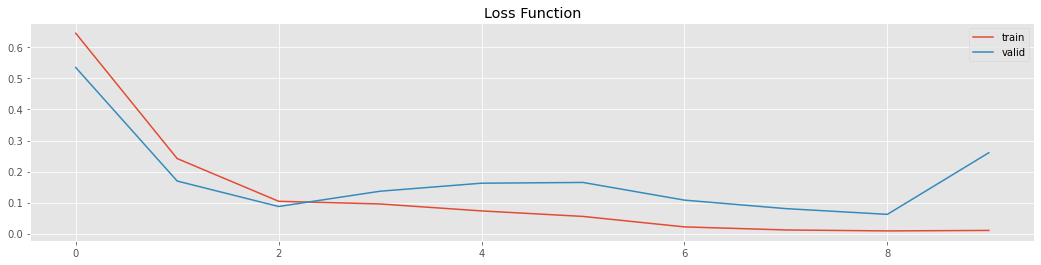

In [18]:
# Plot loss function value through epochs
plt.figure(figsize=(18, 4))
plt.plot(hist.history['loss'], label = 'train')
plt.plot(hist.history['val_loss'], label = 'valid')
plt.legend()
plt.title('Loss Function')
plt.show()

In [19]:
# Plot accuracy through epochs
print(hist.history)

# plt.figure(figsize=(18, 4))
# plt.plot(hist.history['acc'], label = 'train')
# plt.plot(hist.history['val_acc'], label = 'valid')
# plt.legend()
# plt.title('Accuracy')
# plt.show()

{'loss': [0.6457335948944092, 0.24175575375556946, 0.1041475310921669, 0.09545233100652695, 0.07306276261806488, 0.05531318113207817, 0.021546242758631706, 0.011660894379019737, 0.00858164019882679, 0.010174334980547428], 'accuracy': [0.5849999785423279, 0.9449999928474426, 0.9750000238418579, 0.9649999737739563, 0.9800000190734863, 0.9850000143051147, 0.9950000047683716, 0.9950000047683716, 1.0, 0.9950000047683716], 'val_loss': [0.5353301763534546, 0.1693437546491623, 0.08725741505622864, 0.1365230828523636, 0.162388414144516, 0.16477413475513458, 0.10783413052558899, 0.08044084161520004, 0.06194782629609108, 0.26060599088668823], 'val_accuracy': [0.699999988079071, 0.9333333373069763, 1.0, 0.9333333373069763, 0.9333333373069763, 0.9333333373069763, 0.9666666388511658, 0.9666666388511658, 0.9666666388511658, 0.9333333373069763]}


In [20]:
#model_.load_weights('weights.best.inc.male.hdf5')

In [41]:
# Test Data
x_test, y_test = generate_df(2, 'normal', TEST_SAMPLES)

# generate prediction
model_predictions = [np.argmax(model.predict(feature)) for feature in x_test ]

# report test accuracy
test_accuracy = 100 * np.sum(np.array(model_predictions)==y_test) / len(model_predictions)
print('Model Evaluation')
print('Test accuracy: %.4f%%' % test_accuracy)
print('f1_score:', f1_score(y_test, model_predictions))

Model Evaluation
Test accuracy: 100.0000%
f1_score: 1.0


In [47]:
## Confusion Matrix 
print("Test Report ")
print("-------------- ")
print("Confusion Matrix For Test ")
print("--------------------------- ")

print(confusion_matrix(y_test, model_predictions))
print("-------------- ")

print("Test Report ")
print("-------------- ")

print(classification_report(y_test, model_predictions, target_names=("Down","Normal")))
print("----------------------------------------------------------------------- ")


Test Report 
-------------- 
Confusion Matrix For Test 
--------------------------- 
[[15  0]
 [ 0 15]]
-------------- 
Test Report 
-------------- 
              precision    recall  f1-score   support

        Down       1.00      1.00      1.00        15
      Normal       1.00      1.00      1.00        15

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30

----------------------------------------------------------------------- 


In [22]:
#dictionary to name the prediction
gender_target = {0: 'Down'
                , 1: 'Normal'}

def img_to_display(filename):
    # inspired on this kernel:
    # https://www.kaggle.com/stassl/displaying-inline-images-in-pandas-dataframe
    # credits to stassl :)
    
    i = Image.open(filename)
    i.thumbnail((128, 21280), Image.LANCZOS)
    
    with BytesIO() as buffer:
        i.save(buffer, 'png')
        return base64.b64encode(buffer.getvalue()).decode()
    

def display_result(filename, prediction, target):
    '''
    Display the results in HTML
    
    '''

    gender = 'Normal'
    gender_icon = "https://i.imgur.com/nxWan2u.png"
        
    if prediction[1] <= 0.5:
        gender_icon = "https://i.imgur.com/oAAb8rd.png"
        gender = 'Down'
            
    display_html = '''
    <div style="overflow: auto;  border: 2px solid #D8D8D8;
        padding: 5px; width: 420px;" >
        <img src="data:image/jpeg;base64,{}" style="float: left;" width="200" height="200">
        <div style="padding: 10px 0px 0px 20px; overflow: auto;">
            <img src="{}" style="float: left;" width="40" height="40">
            <h3 style="margin-left: 50px; margin-top: 2px;">{}</h3>
            <p style="margin-left: 50px; margin-top: -6px; font-size: 12px">{} prob.</p>
            <p style="margin-left: 50px; margin-top: -16px; font-size: 12px">Real Target: {}</p>
            <p style="margin-left: 50px; margin-top: -16px; font-size: 12px">Filename: {}</p>
        </div>
    </div>
    '''.format(img_to_display(filename)
               , gender_icon
               , gender
               , "{0:.2f}%".format(round(max(prediction)*100,2))
               , gender_target[target]
               , filename.split('/')[-1]
               )

    display(HTML(display_html))

In [23]:
def gender_prediction(filename):
    '''
    predict the gender
    
    input:
        filename: str of the file name
        
    return:
        array of the prob of the targets.
    
    '''
    
    im = cv2.imread(filename)
    im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (32, 32)).astype(np.float32) / 255.0
    im = np.expand_dims(im, axis =0)
    
    # prediction
    result = model.predict(im)
    prediction = np.argmax(result)
    
    return result



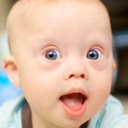


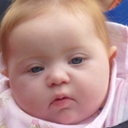


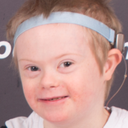


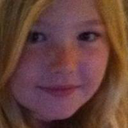


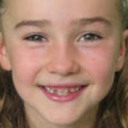


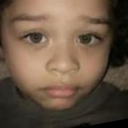


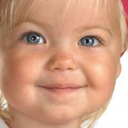


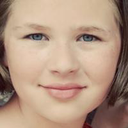


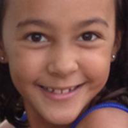


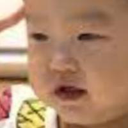


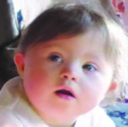


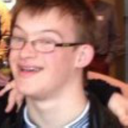


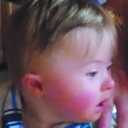


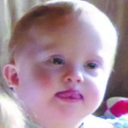


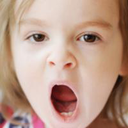


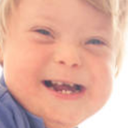


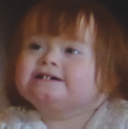


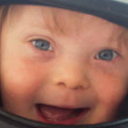


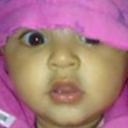


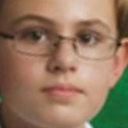


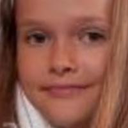


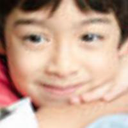


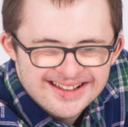


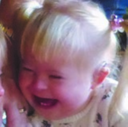


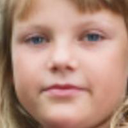


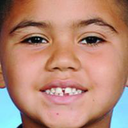


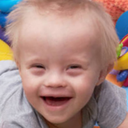


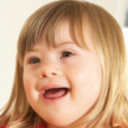


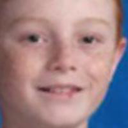


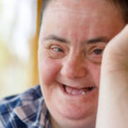


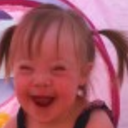


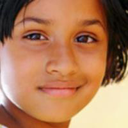


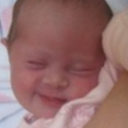


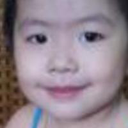


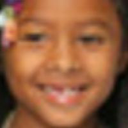


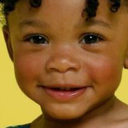


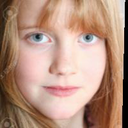


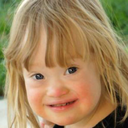


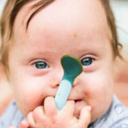


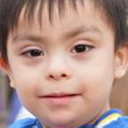

In [24]:
#select random images of the test partition
df_to_test = df_attr[(df_attr['partition'] == 2)].sample(40)

for index, target in df_to_test.iterrows():
    result = gender_prediction('{}{}.png'.format(images_folder, index))
    
    #display result
    display_result('{}{}.png'.format(images_folder, index), result[0], target['normal'])